In [84]:
#import dependences 
import snntorch as snn
import torch
from torchvision import datasets, transforms
from snntorch import utils

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from snntorch import spikegen
import numpy as np

dtype = torch.float
torch.set_default_dtype(dtype)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") #uses the GPU when is available

In [85]:
audio_stim = np.load('auditory_stimuli.npz') #load the mpz file as the auditory stimulus the keys are x_train, y_train, x_test, y_test
X_train_raw = audio_stim['X_train'] #size of (2100, 129, 81) number of samples x frequency x time 
X_test_raw = audio_stim['X_test'] #size of (900, 129, 81)
y_train = audio_stim['y_train'] #size (2100 by 1)
y_test = audio_stim['y_test'] #size of 900 by 1



#print(X_train_raw.shape, y_train.shape, X_test_raw.shape, y_test.shape) #(2100, 129, 81) (2100,) (900, 129, 81) (900,)

In [86]:
'''
X_train = np.zeros([
    np.size(X_train_raw,0),
    np.size(X_train_raw,1) * np.size(X_train_raw,2)
]) #this is a 2100 by 10449 array of zeros

X_test = np.zeros([
    np.size(X_test_raw,0),
    np.size(X_test_raw,1) * np.size(X_test_raw,2)
]) #this is 900 by 10449

for i in range(np.size(X_train_raw,0)): #from 0 to 2100
    X_train[i,:] = np.ravel(X_train_raw[i,:,:]) #x_train(i,:) is being set to the flatten version of 1x129x81 of the raw data

for i in range(np.size(X_test_raw,0)):
    X_test[i,:] = np.ravel(X_test_raw[i,:,:]) #same flatten procedure as the for loop above
    
    #this cell ends with x_train and x_test, being arrays containing the flatten version of the raw data in each cell
'''
X_train = X_train_raw
X_test = X_test_raw

In [87]:
# Dataloader arguments
batch_size = 128*4 #set the batch size to 512 

# Define a transform
transform = transforms.Compose([
    transforms.ToTensor()
])

training_dataset = TensorDataset(
    torch.from_numpy(X_train.astype(np.float32)),
    torch.from_numpy(y_train.astype(np.float32))
) # creates a tensor of float32 containing the training data and label 

testing_dataset = TensorDataset(
    torch.from_numpy(X_test.astype(np.float32)),
    torch.from_numpy(y_test.astype(np.float32))
) #creates a dataset for testing containihng data and label in a float32 format

# Create DataLoaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True) 
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [88]:
num_epochs = 100 #control the number of epochs in the training
loss_hist = []
test_loss_hist = []
counter = 0

# Define Network
class AudNet(nn.Module):
	#no inputs for init,, 1000 hidden layers, 10 outputs, 81 steps, frequency 129, 
	def __init__(self,
		num_inputs=None, num_hidden=1000, num_last_hidden=20, num_output=10,
		beta=0.95, num_steps=81, num_freq=129):
		super().__init__()

		if num_inputs is None:
			num_inputs = num_steps * num_freq #number of inputs will be set by multiplying steps by frequency, or 129*81 if number of inputs is 0

		self.num_steps = num_steps
		self.num_freq = num_freq

		# Initialize layers 
		self.fc1 = nn.Linear(num_inputs, num_hidden) #first layer with num_inputs inputs and 1000 hidden 
		self.lif1 = snn.Leaky(beta=beta) #first layer of spiking neuro network, controlled by beta 
		self.fc2 = nn.Linear(num_hidden, num_hidden)
		self.lif2 = snn.Leaky(beta=beta)
		self.fc3 = nn.Linear(num_hidden, num_last_hidden)
		self.lif3 = snn.Leaky(beta=beta)
		self.fc4 = nn.Linear(num_last_hidden, num_output)
		self.lif4 = snn.Leaky(beta=beta)


	def forward(self, x):

		x.to(torch.float32) #converts x to a float32 
		n = x.shape[0] #sets n to the first dimension of x

		# Initialize hidden states at t=0
		mem1 = self.lif1.init_leaky()
		mem2 = self.lif2.init_leaky()
		mem3 = self.lif3.init_leaky()
		mem4 = self.lif3.init_leaky() #why lif3 and not lif4

		output_spike_record = []
		output_memV_record = []

		for step in range(self.num_steps):

			x_ = x.reshape(n, self.num_freq, self.num_steps)[:,:,step] #sets x_ to be the same dimensions as the original data 

			cur1 = self.fc1(x_) 
			spk1, mem1 = self.lif1(cur1, mem1)

			cur2 = self.fc2(spk1)
			spk2, mem2 = self.lif2(cur2, mem2)

			cur3 = self.fc3(spk2)
			spk3, mem3 = self.lif3(cur3, mem3)

			cur4 = self.fc4(spk3)
			spk4, mem4 = self.lif4(cur4, mem4)

			output_spike_record.append(spk4)
			output_memV_record.append(mem4)

		self.mem1 = mem1
		self.mem2 = mem2
		self.mem3 = mem3

		return  torch.stack(output_spike_record, dim=0), torch.stack(output_memV_record, dim=0)

	def fwd_frozen(self, x):

		mem1 = self.mem1
		mem2 = self.mem2
		mem3 = self.mem3

		last_hidden_spike_record = []
		last_hidden_output_memV_record = []

		for step in range(self.num_steps):

			x_ = x.reshape(self.num_freq, self.num_steps)[:,step]

			cur1 = self.fc1(x_)
			spk1, mem1 = self.lif1(cur1, mem1)

			cur2 = self.fc2(spk1)
			spk2, mem2 = self.lif2(cur2, mem2)

			cur3 = self.fc3(spk2)
			spk3, mem3 = self.lif3(cur3, mem3)

			last_hidden_spike_record.append(spk3)
			last_hidden_output_memV_record.append(mem3)

		return torch.stack(last_hidden_spike_record, dim=0), torch.stack(last_hidden_output_memV_record, dim=0)



In [89]:
input_sz = np.size(X_train, 1) #sets input size to  the second dimension of x_train. For us 129
# Load the network onto CUDA if available
net = AudNet(num_inputs=input_sz).to(device) #loads the data using 129 as the number of inputs
#print("network loaded")

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
	output, _ = net(data)
	_, idx = output[-1].max(1)
	acc = np.mean((targets == idx).detach().cpu().numpy())

	# if train:
	#     print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
	# else:
	print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

#print("function print_batch_accuracy created")

def train_printer():
	print(f"Epoch {epoch}, Iteration {iter_counter}, Train loss = {loss_hist[counter]:.2f} Test loss = {test_loss_hist[counter]:.2f} \n")
	print_batch_accuracy(data, targets)
	print('\n')

#print("train_printer created")

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

# Outer training loop
for epoch in range(num_epochs):
	iter_counter = 0
	train_batch = iter(train_loader)
	#print(epoch)
	# Minibatch training loop
	for data, targets in train_batch:
		data = data.to(device)
		targets = targets.to(device)
		#print(data)
		#print(targets)
		# forward pass
		net.train()
		#print("network trained")
		#spk_rec, mem_rec = net(data.view(batch_size, -1)) #batch x freq * freq*num_steps x hidden 
		spk_rec, mem_rec = net(data)
		#print("spk_rec, mem_rec")
		# initialize the loss & sum over time
		# loss_val = torch.zeros((1), dtype=dtype, device=device)
		loss_val = loss(mem_rec[-1], targets.type(torch.long))

		# Gradient calculation + weight update
		optimizer.zero_grad()
		loss_val.backward()
		optimizer.step()

		# Store loss history for future plotting
		loss_hist.append(loss_val.item())

		# Test set
		with torch.no_grad():
			net.eval()
			test_data, test_targets = next(iter(test_loader))
			test_data = test_data.to(device)
			test_targets = test_targets.to(device)

			# Test set forward pass
			#test_spk, test_mem = net(test_data.view(batch_size, -1))
			test_spk, test_mem  = net(test_data)

			# Test set loss
			# test_loss = torch.zeros((1), dtype=dtype, device=device)
			# for step in range(num_steps):
			test_loss = loss(test_mem[-1], test_targets.type(torch.long))
			test_loss_hist.append(test_loss.item())

			# Print train/test loss/accuracy
			if counter % 50 == 0:
				train_printer()
			counter += 1
	 
		iter_counter +=1

Epoch 0, Iteration 0, Train loss = 3.18 Test loss = 2.82 

Test set accuracy for a single minibatch: 10.55%


Epoch 12, Iteration 2, Train loss = 1.24 Test loss = 1.34 

Test set accuracy for a single minibatch: 29.30%


Epoch 25, Iteration 0, Train loss = 0.83 Test loss = 1.10 

Test set accuracy for a single minibatch: 47.46%


Epoch 37, Iteration 2, Train loss = 0.66 Test loss = 0.90 

Test set accuracy for a single minibatch: 67.38%


Epoch 50, Iteration 0, Train loss = 0.36 Test loss = 0.80 

Test set accuracy for a single minibatch: 83.59%


Epoch 62, Iteration 2, Train loss = 0.20 Test loss = 0.87 

Test set accuracy for a single minibatch: 88.28%


Epoch 75, Iteration 0, Train loss = 0.16 Test loss = 0.87 

Test set accuracy for a single minibatch: 88.48%


Epoch 87, Iteration 2, Train loss = 0.08 Test loss = 0.98 

Test set accuracy for a single minibatch: 91.41%




In [90]:
#train_printer()

In [91]:
data.view(batch_size, -1).shape

torch.Size([512, 10449])

In [92]:
129*81

10449

In [93]:
output, _ = net(data.view(batch_size, -1))
output.shape

torch.Size([81, 512, 10])

In [94]:
_, idx = output.max(1)
# acc = np.mean((targets == idx).detach().cpu().numpy())

In [95]:
test_mem.shape, test_targets.type(torch.long).shape

(torch.Size([81, 512, 10]), torch.Size([512]))

In [96]:
X_train.shape

(2100, 129, 81)

In [97]:
from scipy.signal import spectrogram

In [98]:
_, _, s = spectrogram(X_train[2,:], fs=8000)

/tmp/ipykernel_361/2150500970.py:1: UserWarning: nperseg = 256 is greater than input length  = 81, using nperseg = 81
  _, _, s = spectrogram(X_train[2,:], fs=8000)


In [99]:
X_train[0,:].shape

(129, 81)

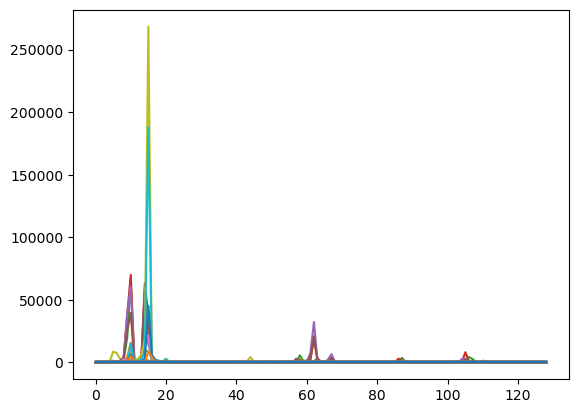

In [100]:
plt.plot(X_train[2,:])

In [101]:
s.shape

(129, 41, 1)

(0.0, 20.0)

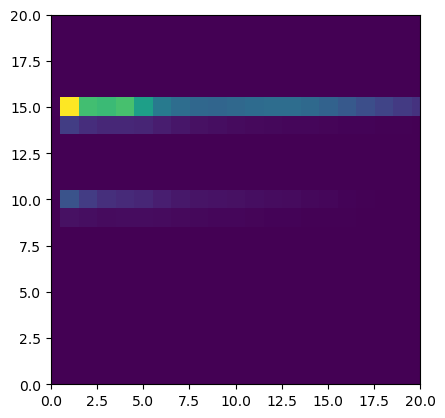

In [102]:
plt.imshow(s)
plt.xlim([0,20])
plt.ylim([0,20])

Text(0.5, 0, 'samples')

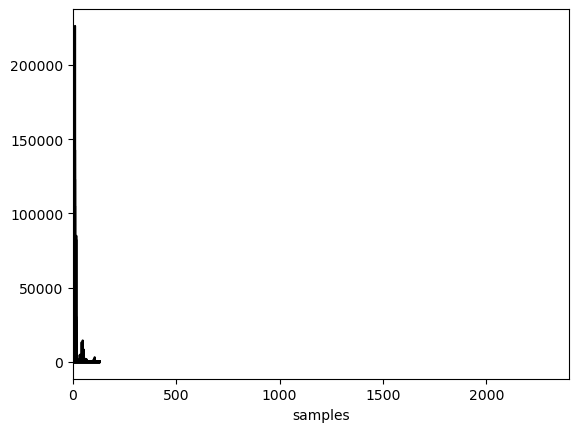

In [103]:
plt.plot(X_train[1,:], 'k')
plt.xlim([0,2400])
plt.xlabel('samples')

In [104]:
print(data.shape, targets.shape)

torch.Size([512, 129, 81]) torch.Size([512])


In [105]:
mem_rec.shape

torch.Size([81, 512, 10])

In [106]:
test_mem.shape

torch.Size([81, 512, 10])

In [107]:
test_targets.shape

torch.Size([512])

In [108]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
spk_rec.shape, mem_rec.shape

(torch.Size([81, 512, 10]), torch.Size([81, 512, 10]))

In [109]:
for param in net.parameters():
    print(param.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
